<a href="https://colab.research.google.com/github/Rafael-Franca90/MVP/blob/main/MVP_Pedidos_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Rafael Moreno Soledade França

**Matrícula:** 4052025000202

**Dataset:** df_pedidos e df_insucesso

# Descrição do Problema

O cumprimento do prazo de entrega de pedidos é um fator crítico para a satisfação do cliente e a eficiência operacional de qualquer empresa. Neste contexto, o objetivo deste projeto é realizar uma análise exploratória e um pré-processamento de dados relacionados ao cumprimento do SLA (Service Level Agreement) de entregas da empresa, com base em pedidos realizados no mês de abril de 2025.

# Hipóteses do Problema



A seguir, estão as perguntas que guiarão nossa análise:

*   Existem transportadoras que estão entregando fora do prazo sem motivo de insucesso?
*   Existe algum dia da que tem uma maior concentração de pedidos entregues em atrasos?
*   Certos tipos de insucesso acontecem mais em algumas modalidades de entregas?


# Tipo de Problema

Este projeto se enquadra inicialmente em dois tipos de análise:

* Análise Descritiva, que busca entender o que está acontecendo com os dados de entrega — frequência de atrasos, distribuição por cidade, transportadora, dia da semana, etc.

* Análise Diagnóstica, que vai além da descrição e tenta responder por que os atrasos acontecem, por meio da investigação de padrões, cruzamento com os dados de insucesso e identificação de causas recorrentes.

No entanto, como etapa preparatória para um modelo de machine learning supervisionado (regressão logística), esta análise também contempla a criação da variável-alvo binária atraso, que será utilizada futuramente para prever a probabilidade de atraso em novos pedidos.

Assim, embora este notebook ainda se concentre em análises exploratórias e diagnósticas, já está estruturado para evoluir em direção a uma abordagem preditiva, com foco em apoiar a tomada de decisão e a gestão proativa da operação logística.

# Seleção de Dados

A análise se baseia em duas fontes de dados principais:

*   A Base, que contém informações operacionais sobre os pedidos, como data prometida, data de entrega, canal de venda, transportadora, filial, entre outros.
*   A Base Insucesso, que descreve os casos em que houve falha ou dificuldade na entrega, classificando o tipo de insucesso ocorrido.


A partir dessas informações, buscamos identificar padrões, anomalias e fatores que impactam diretamente o cumprimento do prazo de entrega, bem como compreender os principais motivos de falhas logísticas.

# Atributos dos Datasets



* **Base**  
>* Data_Performance: Data prometida de entrega ao cliente.
>* Cidade: Cidade de destino da entrega.
>* Documento: Número identificador único do pedido.
>* Canal: Canal de origem da venda (On, Off).
>* Transportador: Empresa responsável pelo transporte.
>* Modadalidade: Tipo/modalidade de entrega.
>* DataExpedicao: Data em que o pedido saiu do centro de distribuição.
>* Data_Limite_ExpedicaoETL: Prazo interno para expedição.
>* StatusDoPedido: Situação atual do pedido (ex: Encerrado).
>* DataEntregaCliente: Data efetiva da entrega.
>* DataIntegracao: Data de aprovação do pedido

* **Base Insucesso**  
>* Documento: Número do pedido (chave para cruzamento).
>* DatadoTracking: Data do registro do insucesso.
>* DescricaoDoTracking: Descrição detalhada do motivo.
>* Insucesso: Macroclassificação da falha (Cliente, Transporte, Loja, etc.)

# 📦 Entrega de Pedidos — EDA, Pré-processamento & Diagnóstico


## 🔧 Importação de bibliotecas


In [183]:
# Manipulação, análise e visualização
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento e modelagem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configurações gerais
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="whitegrid")

# Exibição em Markdown no notebook
from IPython.display import Markdown, display


## 📂 Carregando bases de dados  
* `df_pedidos` – pedidos e prazos  
* `df_insucesso` – primeiro motivo de falha por pedido


In [184]:
URL_PEDIDOS   = 'https://raw.githubusercontent.com/Rafael-Franca90/MVP/main/Base.csv'
URL_INSUCESSO = 'https://raw.githubusercontent.com/Rafael-Franca90/MVP/main/Insucesso.csv'

df_pedidos = pd.read_csv(URL_PEDIDOS, sep=';', encoding='latin1')
df_insucesso = pd.read_csv(URL_INSUCESSO, sep=';', encoding='utf-8')

print('Pedidos:', df_pedidos.shape, '| Insucesso:', df_insucesso.shape)


Pedidos: (82184, 11) | Insucesso: (13236, 4)


## 🔍 Estrutura bruta das colunas Df_Pedidos


In [185]:
df_pedidos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82184 entries, 0 to 82183
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Data_Performance     82184 non-null  object
 1   Cidade               82184 non-null  object
 2   Documento            82184 non-null  int64 
 3   Canal                82184 non-null  object
 4   Transportador        74165 non-null  object
 5   Modadalidade         82184 non-null  object
 6   DataExpedicao        72337 non-null  object
 7   DataLimiteExpedicao  81763 non-null  object
 8   StatusDoPedido       82184 non-null  object
 9   DataEntregaCliente   72299 non-null  object
 10  DataIntegracao       82184 non-null  object
dtypes: int64(1), object(10)
memory usage: 6.9+ MB


### 🗓️ Formatações necessarias


In [186]:
df_pedidos["Documento"] = df_pedidos["Documento"].astype("string")

date_cols = ['DataEntregaCliente', 'DataLimiteExpedicao', 'Data_Performance', 'DataExpedicao', 'DataIntegracao']
for col in date_cols:
    df_pedidos[col] = pd.to_datetime(df_pedidos[col], errors='coerce', dayfirst=True)

# Verificar novamente
df_pedidos[date_cols].head()
print('\nDepois da conversão:')
df_pedidos.info()
df_pedidos


Depois da conversão:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82184 entries, 0 to 82183
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data_Performance     82184 non-null  datetime64[ns]
 1   Cidade               82184 non-null  object        
 2   Documento            82184 non-null  string        
 3   Canal                82184 non-null  object        
 4   Transportador        74165 non-null  object        
 5   Modadalidade         82184 non-null  object        
 6   DataExpedicao        72337 non-null  datetime64[ns]
 7   DataLimiteExpedicao  81763 non-null  datetime64[ns]
 8   StatusDoPedido       82184 non-null  object        
 9   DataEntregaCliente   72299 non-null  datetime64[ns]
 10  DataIntegracao       82184 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(5), string(1)
memory usage: 6.9+ MB


,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao
0,2025-04-01,SAO PAULO,2756432071,On,A,Carro,2025-04-01,2025-04-01,ENCERRADO,2025-04-01,2025-03-28
1,2025-04-02,SAO PAULO,2756757711,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-03,2025-03-29
2,2025-04-02,SAO PAULO,2757318421,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-04,2025-03-31
3,2025-04-03,GUARULHOS,2757536071,Off,C,Carro,2025-04-03,2025-04-03,ENCERRADO,2025-04-03,2025-04-01
4,2025-04-07,SAO PAULO,2758708361,On,A,Carro,2025-04-07,2025-04-07,ENCERRADO,2025-04-07,2025-04-05
...,...,...,...,...,...,...,...,...,...,...,...
82179,2025-04-15,ITARIRI,2760819961,Off,NaN,Toco,NaT,2025-04-14,CANCELADO,NaT,2025-04-11
82180,2025-04-03,MAUA,2757780951,Off,NaN,Carro,NaT,2025-04-03,CANCELADO,NaT,2025-04-02
82181,2025-04-24,SAO PAULO,2763133431,Off,NaN,Carro,NaT,2025-04-24,CANCELADO,NaT,2025-04-19
82182,2025-04-14,SAO PAULO,2760673461,Off,G,Carro,2025-04-14,2025-04-14,ENCERRADO,2025-04-14,2025-04-11


## 🅰️.1 Exploração de Dados (EDA) Df_Pedidos



### 1. Verificar linhas duplicadas
Preciso garantir linhas completas distintas e com a coluna Documento distinto, posteriormente irei utiliza-la como chave primaria.


In [187]:
# Etapa 1: Verificar duplicatas exatas (linha completa)
df_dups = (
    df_pedidos[df_pedidos.duplicated(keep=False)]
        .sort_values('Documento')
)

print(
    f"Duplicatas exatas: {len(df_dups):,} linhas  "
    f"({len(df_dups) / len(df_pedidos):.2%} do dataset)"
)
df_dups.head()


Duplicatas exatas: 332 linhas  (0.40% do dataset)


,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao
58852,2025-04-11,SANTOS,2738898611,On,E,Carro,NaT,2025-03-23,CANCELADO,NaT,2025-01-31
58854,2025-04-11,SANTOS,2738898611,On,E,Carro,NaT,2025-03-23,CANCELADO,NaT,2025-01-31
8913,2025-04-08,MAUA,2738899362,On,F,Carro,NaT,NaT,CANCELADO,NaT,2025-01-31
8912,2025-04-08,MAUA,2738899362,On,F,Carro,NaT,NaT,CANCELADO,NaT,2025-01-31
52527,2025-04-04,S BERNARD CAMPO,2739444602,On,B,Carro,NaT,NaT,CANCELADO,NaT,2025-02-02


### 2. Removendo as linhas duplicadas (mantendo a primeira ocorrência)

In [188]:
#Etapa 1 Contar linhas removidas
antes = len(df_pedidos)
df_pedidos = df_pedidos.drop_duplicates(keep='first').reset_index(drop=True)
print(f"{antes - len(df_pedidos):,} linhas removidas · Dataset final: {len(df_pedidos):,}")


204 linhas removidas · Dataset final: 81,980


### 3. Criando flag atraso e KPI inicial


Verificar se todas as linhas das colunas DataEntregaCliente e Data_Performance que são premissas para calcular a flag de atraso estão preenchidas.

In [189]:
# Verifica valores ausentes
faltantes = df_pedidos[['DataEntregaCliente', 'Data_Performance']].isna().sum()

# Mostra o total de linhas faltantes por coluna
print("🔍 Valores ausentes por coluna:")
print(faltantes)

🔍 Valores ausentes por coluna:
DataEntregaCliente    9776
Data_Performance         0
dtype: int64


Sera necessario remover para não causar distorções nas analises

In [190]:
# Remove pedidos com falha em uma das duas datas essenciais
df_pedidos = df_pedidos.dropna(subset=['DataEntregaCliente', 'Data_Performance']).reset_index(drop=True)

Agora eu crio a sinalização de atraso

In [191]:
# Criando flag binária de atraso
df_pedidos['atraso'] = (df_pedidos['DataEntregaCliente'] > df_pedidos['Data_Performance']).astype(int)

# Cálculo da % de atraso
impacto_total = df_pedidos['atraso'].mean() * 100
print(f'🚛  % de pedidos com atraso: {impacto_total:.1f}%')

# Distribuição detalhada
contagem = df_pedidos['atraso'].value_counts().sort_index()
percentual = df_pedidos['atraso'].value_counts(normalize=True).sort_index() * 100

# Exibindo distribuição
print("\nDistribuição de atrasos:")
for classe in contagem.index:
    nome = "No prazo" if classe == 0 else "Atrasado"
    print(f"{nome}: {contagem[classe]} pedidos ({percentual[classe]:.1f}%)")


🚛  % de pedidos com atraso: 8.9%

Distribuição de atrasos:
No prazo: 65785 pedidos (91.1%)
Atrasado: 6419 pedidos (8.9%)


### 4. Distribuição de Atraso por Faixa
Esta seção avalia a distribuição dos atrasos


#### Representatividade de atraso por categoria


Top 3 com maior atraso - Transportador


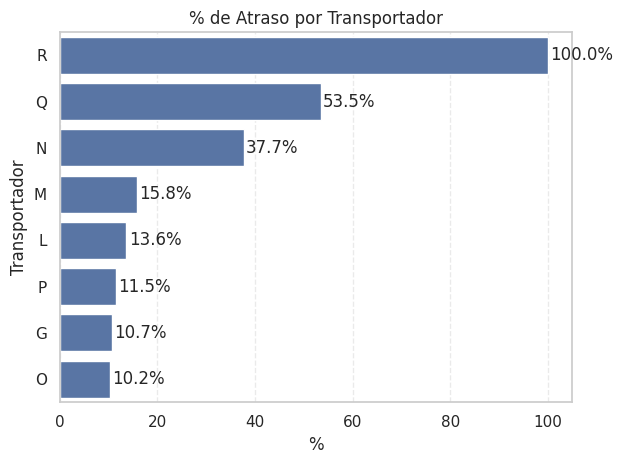

R   100.00
Q    53.46
N    37.66

Top 3 com maior atraso - Canal


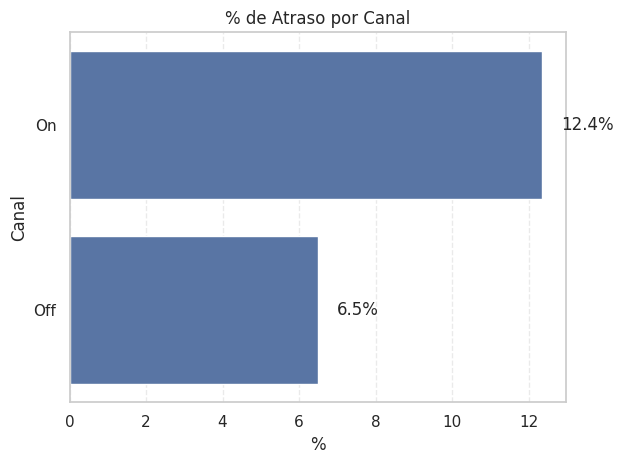

On    12.36
Off    6.49

Top 3 com maior atraso - Cidade


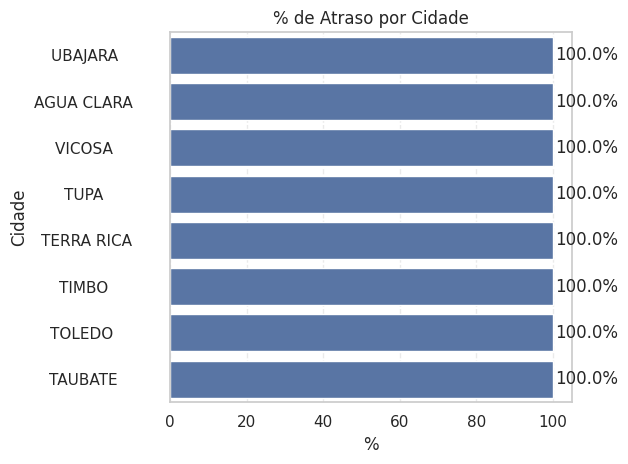

UBAJARA           100.00
AGUA CLARA        100.00
VICOSA            100.00


In [192]:
# Definir função
def plot_atraso(col, top=8):
    taxa = (
        df_pedidos.groupby(col)['atraso']
        .mean()
        .sort_values(ascending=False) * 100
    )

    top_taxa = taxa.head(top)
    ax = sns.barplot(y=top_taxa.index, x=top_taxa.values)

    # Adiciona os valores nas barras
    for i, v in enumerate(top_taxa.values):
        ax.text(v + 0.5, i, f'{v:.1f}%', va='center')

    plt.title(f'% de Atraso por {col}')
    plt.xlabel('%'); plt.ylabel(col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    return top_taxa.head(3)

# Gerar gráfico para principais categorias
for col in ['Transportador', 'Canal', 'Cidade']:
    print(f'\nTop 3 com maior atraso - {col}')
    print(plot_atraso(col).to_string(header=False))


#### Distribuição da volumetria de atrasos

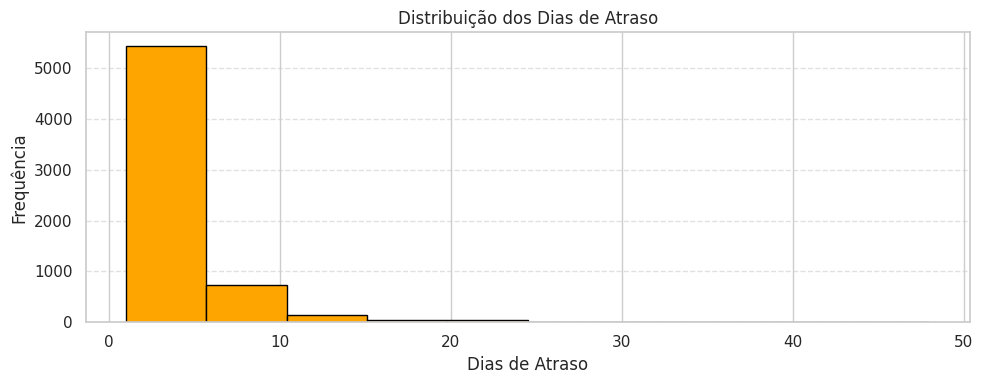

In [193]:
# Gerar coluna com dias de atraso (apenas onde houve atraso)
df_pedidos['dias_atraso'] = (
    (df_pedidos['DataEntregaCliente'] - df_pedidos['Data_Performance'])
    .dt.days.clip(lower=0)
)

# Histograma da distribuição de dias de atraso
plt.figure(figsize=(10, 4))
plt.hist(
    df_pedidos[df_pedidos['atraso'] == 1]['dias_atraso'],
    color='orange', edgecolor='black'
)
plt.title('Distribuição dos Dias de Atraso')
plt.xlabel('Dias de Atraso'); plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Sera necessario criar faixas de atrasos

#### Distribuição da volumetria de atrasos por Faixa

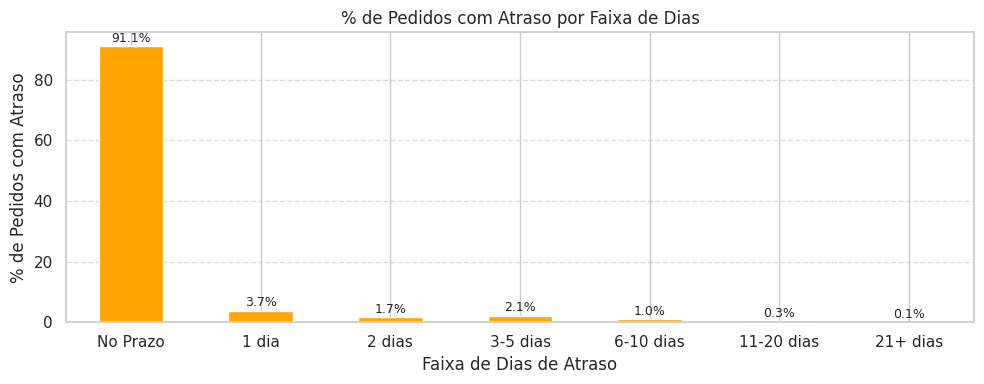

In [194]:

# Etapa 1: Define as faixas de dias de atraso
bins = [0 ,1, 2, 3, 6, 11, 21, np.inf]
labels = ['No Prazo', '1 dia', '2 dias', '3-5 dias', '6-10 dias', '11-20 dias', '21+ dias']


# Etapa 2: Classifica os atrasos em faixas
df_pedidos['faixa_atraso'] = pd.cut(
    df_pedidos['dias_atraso'],
    bins=bins,
    labels=labels,
    right=False
)

# Etapa 3: Calcula percentual por faixa
frequencias_pct = (df_pedidos['faixa_atraso'].value_counts(normalize=True)
                   .sort_index() * 100)

# Etapa 4: Gráfico de barras em percentual
plt.figure(figsize=(10, 4))
frequencias_pct.plot(kind='bar', color='orange')
plt.title('% de Pedidos com Atraso por Faixa de Dias')
plt.xlabel('Faixa de Dias de Atraso')
plt.ylabel('% de Pedidos com Atraso')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# Etapa 5: Adiciona rótulo de valor em cima das barras
for i, valor in enumerate(frequencias_pct):
    plt.text(i, valor + 0.5, f'{valor:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 5. Verificação de Outliers atraves de analise de quartis

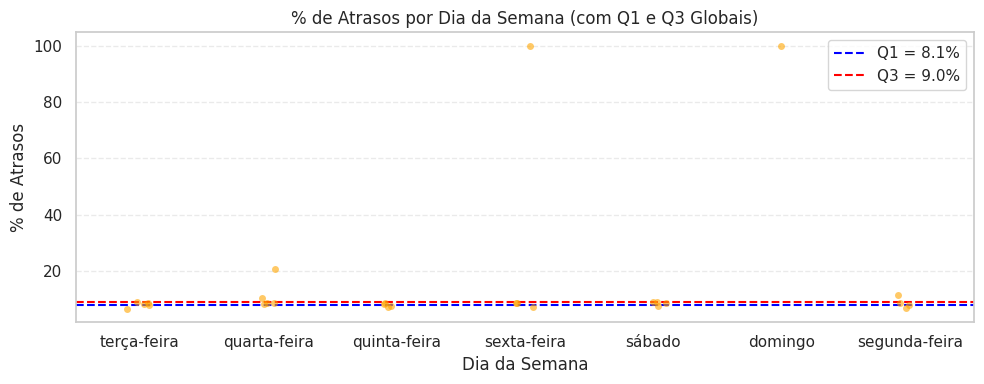


🔵 Datas com % de atrasos abaixo de Q1 (8.1%):
                  percentual_atrasos
Data_Performance                    
2025-04-01                      8.06
2025-04-05                      7.49
2025-04-10                      7.14
2025-04-11                      7.14
2025-04-24                      7.62
2025-04-28                      7.07
2025-04-29                      6.58

🔴 Datas com % de atrasos acima de Q3 (9.0%):
                  percentual_atrasos
Data_Performance                    
2025-04-13                    100.00
2025-04-16                     10.60
2025-04-18                    100.00
2025-04-19                      8.98
2025-04-21                     11.66
2025-04-26                      9.23
2025-04-30                     20.82


In [195]:
# Etapa 1: Prepara os dados
df_pedidos['dias_atraso'] = (df_pedidos['DataEntregaCliente'] - df_pedidos['Data_Performance']).dt.days.clip(lower=0)
df_pedidos['atraso'] = df_pedidos['dias_atraso'] > 0

# Etapa 2: Agrega por dia e calcula o percentual de atrasos
df_diario = (
    df_pedidos
    .set_index('Data_Performance')
    .resample('D')
    .agg(
        total_pedidos=('atraso', 'size'),
        atrasados=('atraso', 'sum')
    )
    .dropna()
)
df_diario['percentual_atrasos'] = df_diario['atrasados'] / df_diario['total_pedidos'] * 100

# Adiciona nome do dia da semana
weekday_map = {0: 'segunda-feira', 1: 'terça-feira', 2: 'quarta-feira',
               3: 'quinta-feira', 4: 'sexta-feira', 5: 'sábado', 6: 'domingo'}
df_diario['weekday_name'] = df_diario.index.dayofweek.map(weekday_map)

# Etapa 3: Calcula quartis do percentual de atrasos
q1_percent = df_diario['percentual_atrasos'].quantile(0.25)
q3_percent = df_diario['percentual_atrasos'].quantile(0.75)

# Etapa 4: Visualiza gráfico com Q1 e Q3
plt.figure(figsize=(10, 4))
sns.stripplot(data=df_diario, x='weekday_name', y='percentual_atrasos', color='orange', alpha=0.6, jitter=True)
plt.axhline(q1_percent, color='blue', linestyle='--', label=f'Q1 = {q1_percent:.1f}%')
plt.axhline(q3_percent, color='red', linestyle='--', label=f'Q3 = {q3_percent:.1f}%')
plt.title('% de Atrasos por Dia da Semana (com Q1 e Q3 Globais)')
plt.xlabel('Dia da Semana')
plt.ylabel('% de Atrasos')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Etapa 5: Exibe datas fora da faixa interquartil
print(f"\n🔵 Datas com % de atrasos abaixo de Q1 ({q1_percent:.1f}%):")
print(df_diario[df_diario['percentual_atrasos'] < q1_percent][['percentual_atrasos']])

print(f"\n🔴 Datas com % de atrasos acima de Q3 ({q3_percent:.1f}%):")
print(df_diario[df_diario['percentual_atrasos'] > q3_percent][['percentual_atrasos']])


##  Análise Descritiva
*   Existem 8,9% de registros com atraso. Será necessário aplicar balanceamento de classes antes de seguir com o projeto de machine learning baseado em Regressão Logística.
*   A maior parte dos pedidos é entregue no prazo ou com atraso de até 5 dias, o que representa uma concentração leve, porém recorrente.
*   As transportadoras R, Q e N concentram os maiores percentuais de atraso, com destaque absoluto para a transportadora R (100%).
*   O canal "On" (digital) apresenta praticamente o dobro de atraso em comparação ao canal "Off", sinalizando possíveis falhas operacionais no ambiente online.
*   Cidades como UBAJARA, VIÇOSA e TAUBATÉ possuem 100% dos pedidos com atraso, evidenciando gargalos locais críticos.
*   A análise por dia da semana revela que quartas, sextas e domingos concentram os maiores percentuais de atraso, acima do terceiro quartil (Q3) da distribuição global.

**Importante** destacar que existem pedidos sem data de entrega registrada, o que impede o cálculo da flag de SLA para essas ocorrências. Esses casos foram desconsiderados nas análises de atraso para garantir a integridade dos resultados.

## 🅰️.2 Exploração de Dados (EDA) – df_insucesso

### 1. Exibindo o dataset

In [196]:
df_insucesso.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Documento            13236 non-null  int64 
 1   DatadoTracking       13236 non-null  object
 2   DescricaoDoTracking  13236 non-null  object
 3   Insucesso            13236 non-null  object
dtypes: int64(1), object(3)
memory usage: 413.8+ KB


### 2. Formatando Colunas


In [197]:
df_insucesso['DatadoTracking'] = pd.to_datetime(
    df_insucesso['DatadoTracking'],
    errors='coerce', dayfirst=True
)
df_insucesso['Documento'] =  df_insucesso['Documento'].astype("string")

### 3. Panorama das colunas categóricas


Verificar se tem alguma duplicidade, pois posteriomente terei que identificar os insucessos pela coluna documento  no dataset de pedidos

In [198]:
# Etapa 1: Verificar duplicatas exatas
df_dupsInsucesso = (
    df_insucesso[df_insucesso.duplicated(keep=False)]
        .sort_values('Documento')
)

print(
    f"Duplicatas exatas: {len(df_dupsInsucesso):,} linhas  "
    f"({len(df_dupsInsucesso) / len(df_insucesso):.2%} do dataset)"
)
df_dupsInsucesso.head()


Duplicatas exatas: 2,586 linhas  (19.54% do dataset)


,Documento,DatadoTracking,DescricaoDoTracking,Insucesso
3703,2714524911,2024-12-11,PERDA LOGISTICA,Pendencia
3972,2714524911,2024-12-11,PERDA LOGISTICA,Pendencia
4024,2714524911,2024-12-04,PERDA LOGISTICA,Pendencia
4011,2714524911,2024-12-04,PERDA LOGISTICA,Pendencia
1390,2716159471,2025-02-21,PERDA LOGISTICA,Pendencia


Foi constatado que tem duplicidade de numero de documento. Terei que tratar essa coluna. Seguirei identificando apenas o primeiro insucesso de cada documento.

In [199]:
# Ordena do mais antigo para o mais recente
df_insucesso = df_insucesso.sort_values(by='DatadoTracking')

# Mantém apenas o primeiro registro (menor data) por Documento
df_insucesso = df_insucesso.drop_duplicates(subset='Documento', keep='first').reset_index(drop=True)

### 4. Motivos de insucesso mais frequentes


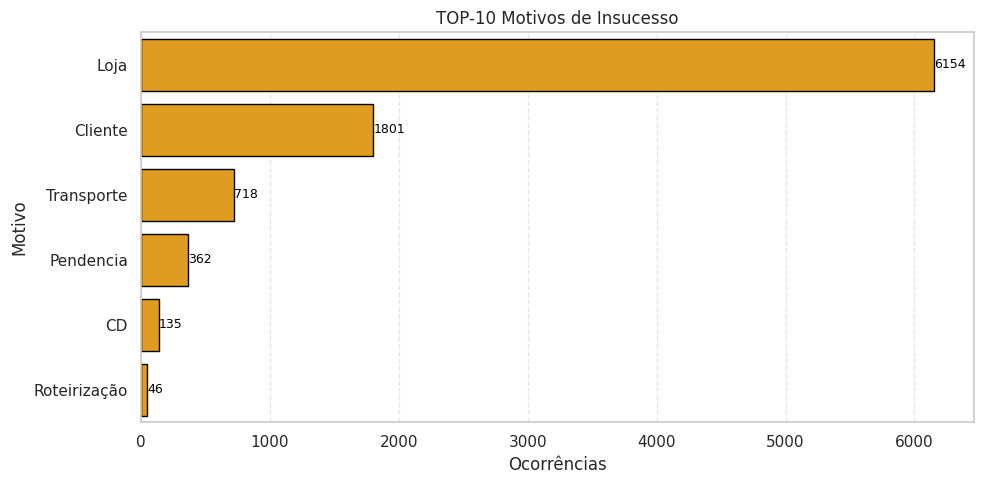

In [200]:
top_mot = df_insucesso['Insucesso'].value_counts().head(10)

plt.figure(figsize=(10, 5))
ax = sns.barplot(y=top_mot.index, x=top_mot.values, color='orange', edgecolor='black')

# Adiciona os valores numéricos no fim de cada barra
for i, v in enumerate(top_mot.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontsize=9)

plt.title('TOP-10 Motivos de Insucesso')
plt.xlabel('Ocorrências')
plt.ylabel('Motivo')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 5. Linha do tempo dos insucessos


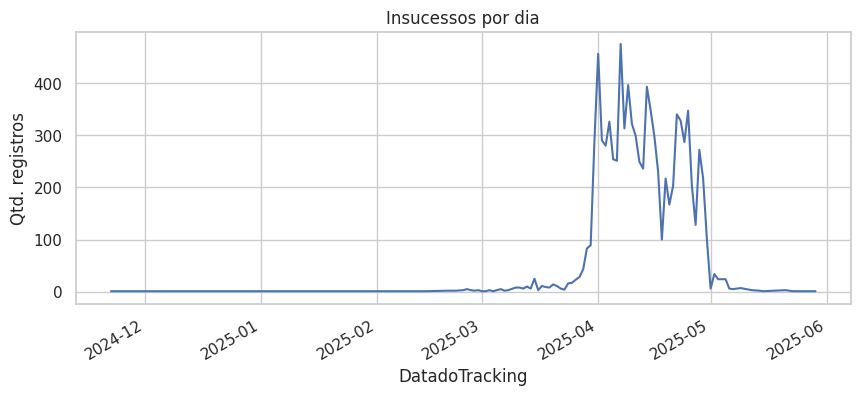

In [201]:
# garante datetime (caso ainda não tenha sido feito)
df_insucesso['DatadoTracking'] = pd.to_datetime(
    df_insucesso['DatadoTracking'], errors='coerce', dayfirst=True
)

# série diária, filtrando zeros/nulos
serie_diaria = (
    df_insucesso
        .set_index('DatadoTracking')['Documento']
        .resample('D').count()
        .loc[lambda s: s > 0]          # elimina dias com 0 ocorrências
)

# gráfico de linha (mesmo tipo original)
serie_diaria.plot(figsize=(10,4))
plt.ylabel('Qtd. registros')
plt.title('Insucessos por dia')
plt.show()


##  Analise Descritiva do df_insucesso

*  Foram identificadas 2.586 linhas duplicadas (19,5% da base), o que indica a necessidade de tratamento prévio para garantir unicidade por Documento, já que essa coluna será usada posteriormente como chave de ligação com o dataset de pedidos.

*  Os motivos mais frequentes de insucesso estão concentrados em "Loja" (6.154 ocorrências) e "Cliente" (1.801 ocorrências), o que sugere problemas operacionais recorrentes tanto no ponto de origem quanto na entrega final. Outros motivos como Transporte, Pendência, CD e Roteirização também aparecem, mas com menor representatividade.

## 🅱️ Pré-processamento  
*Objetivo:* tratar valores ausentes, escalar variáveis e produzir um dataset pronto para modelagem.


### 1. Enriquecendo df_pedidos com o **primeiro** motivo de cada pedido


In [203]:
# ▶︎ garantir datetime
df_insucesso['DatadoTracking'] = pd.to_datetime(
    df_insucesso['DatadoTracking'], errors='coerce', dayfirst=True
)

# 0️⃣ selecionar o PRIMEIRO motivo por Documento
df_first_mot = (
    df_insucesso
      .sort_values('DatadoTracking')                # mais antigo primeiro
      .drop_duplicates(subset='Documento', keep='first')
      .rename(columns={
          'Insucesso'          : 'MotivoMacro',
          'DescricaoDoTracking': 'MotivoDescricao'
      })
      [['Documento', 'MotivoMacro', 'MotivoDescricao']]
)

# Merge left → mantém todos os pedidos
df_prep = df_pedidos.merge(df_first_mot, on='Documento', how='left')

# 🔄 preenche onde não houve join
df_prep['MotivoMacro']     = df_prep['MotivoMacro'].fillna('Sem Atraso Identificado')
df_prep['MotivoDescricao'] = df_prep['MotivoDescricao'].fillna('Sem Atraso Identificado')

### 2. Verificar valores nulos


In [205]:
cat_prep = df_prep.select_dtypes('object').columns.tolist()

sum_ins = (
    pd.DataFrame({
        'n_únicos'  : df_prep[cat_prep].nunique(),
        'missings'  : df_prep[cat_prep].isna().sum(),
        '%_missings': df_prep[cat_prep].isna().mean()*100
    })
    .sort_values('n_únicos', ascending=False)
)
display(sum_ins.style.format({'%_missings':'{:.1f}%'}))


,n_únicos,missings,%_missings
Cidade,1151,0,0.0%
MotivoDescricao,56,0,0.0%
Transportador,19,15,0.0%
MotivoMacro,7,0,0.0%
Modadalidade,5,0,0.0%
StatusDoPedido,3,0,0.0%
Canal,2,0,0.0%


In [206]:
df_prep

,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao,atraso,dias_atraso,faixa_atraso,MotivoMacro,MotivoDescricao
0,2025-04-01,SAO PAULO,2756432071,On,A,Carro,2025-04-01,2025-04-01,ENCERRADO,2025-04-01,2025-03-28,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
1,2025-04-02,SAO PAULO,2756757711,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-03,2025-03-29,True,1,1 dia,Sem Atraso Identificado,Sem Atraso Identificado
2,2025-04-02,SAO PAULO,2757318421,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-04,2025-03-31,True,2,2 dias,Sem Atraso Identificado,Sem Atraso Identificado
3,2025-04-03,GUARULHOS,2757536071,Off,C,Carro,2025-04-03,2025-04-03,ENCERRADO,2025-04-03,2025-04-01,False,0,No Prazo,Loja,DOCUMENTO NAO LIBERADO ATE O MOMENTO DA EMISSA...
4,2025-04-07,SAO PAULO,2758708361,On,A,Carro,2025-04-07,2025-04-07,ENCERRADO,2025-04-07,2025-04-05,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72199,2025-04-15,SAO PAULO,2761331141,On,E,Carro,2025-04-15,2025-04-15,ENCERRADO,2025-04-16,2025-04-13,True,1,1 dia,Sem Atraso Identificado,Sem Atraso Identificado
72200,2025-04-24,SAO PAULO,2762702921,On,B,Carro,2025-04-24,2025-04-24,ENCERRADO,2025-04-28,2025-04-17,True,4,3-5 dias,Sem Atraso Identificado,Sem Atraso Identificado
72201,2025-04-14,SAO PAULO,2761093651,Off,A,Carro,2025-04-14,2025-04-14,ENCERRADO,2025-04-14,2025-04-12,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
72202,2025-04-05,SAO PAULO,2757918851,Off,A,Carro,2025-04-05,2025-04-06,ENCERRADO,2025-04-08,2025-04-02,True,3,3-5 dias,Cliente,CLIENTE AUSENTE 2


## 🔍 Analise  Diagnostica

### Dataframe final pós identificação do motivo de atraso.

In [207]:
df_prep.head()

,Data_Performance,Cidade,Documento,Canal,Transportador,Modadalidade,DataExpedicao,DataLimiteExpedicao,StatusDoPedido,DataEntregaCliente,DataIntegracao,atraso,dias_atraso,faixa_atraso,MotivoMacro,MotivoDescricao
0,2025-04-01,SAO PAULO,2756432071,On,A,Carro,2025-04-01,2025-04-01,ENCERRADO,2025-04-01,2025-03-28,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado
1,2025-04-02,SAO PAULO,2756757711,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-03,2025-03-29,True,1,1 dia,Sem Atraso Identificado,Sem Atraso Identificado
2,2025-04-02,SAO PAULO,2757318421,On,B,Carro,2025-04-02,2025-04-02,ENCERRADO,2025-04-04,2025-03-31,True,2,2 dias,Sem Atraso Identificado,Sem Atraso Identificado
3,2025-04-03,GUARULHOS,2757536071,Off,C,Carro,2025-04-03,2025-04-03,ENCERRADO,2025-04-03,2025-04-01,False,0,No Prazo,Loja,DOCUMENTO NAO LIBERADO ATE O MOMENTO DA EMISSA...
4,2025-04-07,SAO PAULO,2758708361,On,A,Carro,2025-04-07,2025-04-07,ENCERRADO,2025-04-07,2025-04-05,False,0,No Prazo,Sem Atraso Identificado,Sem Atraso Identificado


### Tabela de volumetria por motivo de insucesso


In [208]:
# Cria a tabela dinâmica
tabela_motivos = pd.pivot_table(
    df_prep,
    index='MotivoMacro',
    columns='faixa_atraso',
    values='Documento',
    aggfunc='count',
    margins=True,
    margins_name='Total',
    observed=False
)


# Ordena pela coluna "Total"
tabela_motivos = tabela_motivos.sort_values(by='Total', ascending=False)

# Exibe a tabela com valores absolutos
display(tabela_motivos)

faixa_atraso,No Prazo,1 dia,2 dias,3-5 dias,6-10 dias,11-20 dias,21+ dias,Total
MotivoMacro,,,,,,,,
Total,65785,2704,1241,1489,733,206,46,72204
Sem Atraso Identificado,64810,2351,944,804,293,67,15,69284
Cliente,271,77,132,454,275,86,19,1314
Transporte,116,205,103,110,102,21,2,659
Loja,485,34,20,44,14,8,3,608
Pendencia,87,25,22,42,21,10,4,211
CD,15,9,13,17,18,12,3,87
Roteirização,1,3,7,18,10,2,0,41


### Tabela de representatividade por motivo de insucesso



In [209]:
# Remove a linha "Total" da tabela original para o cálculo correto
tabela_motivos_sem_total = tabela_motivos.drop(index='Total')

# Total geral
total_geral = tabela_motivos.loc['Total', 'Total']

# Calcula percentuais em relação ao total geral
tabela_percentual = (tabela_motivos_sem_total / total_geral * 100).round(1)

# Cria a linha de totais por coluna (exceto "Total", que será fixo em 100%)
linha_total = tabela_motivos.loc['Total'].drop('Total') / total_geral * 100
linha_total['Total'] = 100.0  # fixa o total em 100%

# Adiciona a linha "Total" no final
tabela_percentual.loc['Total'] = linha_total.round(1)

# Exibe resultado
display(tabela_percentual)


faixa_atraso,No Prazo,1 dia,2 dias,3-5 dias,6-10 dias,11-20 dias,21+ dias,Total
MotivoMacro,,,,,,,,
Sem Atraso Identificado,89.80,3.30,1.30,1.10,0.40,0.10,0.00,96.00
Cliente,0.40,0.10,0.20,0.60,0.40,0.10,0.00,1.80
Transporte,0.20,0.30,0.10,0.20,0.10,0.00,0.00,0.90
Loja,0.70,0.00,0.00,0.10,0.00,0.00,0.00,0.80
Pendencia,0.10,0.00,0.00,0.10,0.00,0.00,0.00,0.30
CD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10
Roteirização,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10
Total,91.10,3.70,1.70,2.10,1.00,0.30,0.10,100.00


Somente pedidos fora do prazo

In [210]:
# Seleciona colunas que representam atraso (todas, exceto 'No Prazo' e 'Total')
colunas_atraso = [col for col in tabela_percentual.columns if col not in ['No Prazo', 'Total']]

# Soma por linha apenas as colunas de atraso
tabela_percentual['% Atraso'] = tabela_percentual[colunas_atraso].sum(axis=1)

# Exibe a nova tabela com a coluna de % Atraso
display(tabela_percentual[['% Atraso']])


faixa_atraso,% Atraso
MotivoMacro,
Sem Atraso Identificado,6.20
Cliente,1.40
Transporte,0.70
Loja,0.10
Pendencia,0.10
CD,0.00
Roteirização,0.00
Total,8.90


##  Conclusões da Exploração de Dados do dataset que identifica o motivo do atraso dos pedidos.


*   91,10% dos pedidos foram entregues no prazo, porém apenas 89,80% foram pedidos que tiveram o caminho "feliz" (sem insucesso).
*   7,5% dos atrasos estão concentrados em até 5 dias.

Abaixo, mostra a concentração e o motivo de insucessos que levaram os pedidos serem entregues **FORA DO PRAZO** do cliente.

*   Cliente = 1,40 pp
*   Transporte = 0,70 pp
*   Loja = 0,10 pp
*   Pendencia = 0,10 pp
*   CD = 0,00 pp
*   Roteirização = 0,00pp
*   Sem Atraso Identificado = 6,2 pp.

Totalizando em 8,90% de pedidos entregues fora do prazo.

Chego a conclusão da necessidade de revisão no processo de expedição e transporte. Analise apresentou pedidos sendo entregues para o cliente atrasados sem evidencia de insucesso.

## Preparar o dataset para iniciar o modelo de ML (Regressão Logistica)